# Installations

In [3]:
!pip install Epitran
!pip install eng_to_ipa
!pip install panphon
!pip install -U PyYAML
!pip install googletrans
!pip install googletrans==3.1.0a0

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import panphon
import panphon.distance
import editdistance # levenshtein
import epitran
import eng_to_ipa as eng
from epitran.backoff import Backoff
from googletrans import Translator
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
epitran.download.cedict()

# Looping

In [4]:
dst = panphon.distance.Distance()

In [5]:
edit_dists = [dst.fast_levenshtein_distance, dst.dolgo_prime_distance, \
              dst.feature_edit_distance, dst.hamming_feature_edit_distance, dst.weighted_feature_edit_distance, \
              dst.fast_levenshtein_distance_div_maxlen]
edit_dists_names = ["Fast Levenshtein", "Dolgo Prime Distance", \
                    "Feature Edit Distance", "Hamming Feature Distance", "Weighted Feature Distance", \
                    "Fast Levenshtein Distance Div Maxlen"]

example of distances using two words "hmjʃh" and "motor"


In [6]:
for dist, name  in zip(edit_dists, edit_dists_names):
  print(f"{name} : {dist('hmjʃh', 'motor')}")

Fast Levenshtein : 5
Dolgo Prime Distance : 3
Feature Edit Distance : 1.4375
Hamming Feature Distance : 1.6666666666666667
Weighted Feature Distance : 22.5
Fast Levenshtein Distance Div Maxlen : 1.0


In [7]:
L1_L2 = pd.read_csv("Hindi-Persian.csv")
L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'..."
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/']
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a..."
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/']
4,अंदरुनी,اندرونی,"['/ən.d̪ə.ɾʊ.niː/', '[ə̃n̪.d̪ə.ɾʊ.n̪iː]']",[]


## Working with EpiTran's IPAs

In [8]:
epi = epitran.Epitran('hin-Deva')

In [9]:
L1_L2["loan_word_epitran"] = L1_L2.apply(lambda x:epi.transliterate(x["loan_word"]), axis=1)

In [10]:
epi = epitran.Epitran('fas-Arab')

In [11]:
L1_L2["original_word_epitran"] = L1_L2.apply(lambda x:epi.transliterate(x["original_word"]), axis=1)

In [12]:
L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,loan_word_epitran,original_word_epitran
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'...",ŋɡuːr,ɒŋvr
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/'],ŋɡuːriː,ɒŋvrj
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a...",ɲd͡ʒaːm,ɒnd͡ʒɒm
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/'],ndər,ɒndr
4,अंदरुनी,اندرونی,"['/ən.d̪ə.ɾʊ.niː/', '[ə̃n̪.d̪ə.ɾʊ.n̪iː]']",[],ndəruniː,ɒndrvnj


In [13]:
L1_L2.shape

(1361, 6)

In [14]:
Epi_L1_L2 = L1_L2.drop(["original_word_ipas", "loan_word_ipas"], axis=1)

In [15]:
Epi_L1_L2.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran
0,अंगूर,انگور,ŋɡuːr,ɒŋvr
1,अंगूरी,انگوری,ŋɡuːriː,ɒŋvrj
2,अंजाम,انجام,ɲd͡ʒaːm,ɒnd͡ʒɒm
3,अंदर,اندر,ndər,ɒndr
4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj


In [16]:
for dist, name  in zip(edit_dists, edit_dists_names):
    Epi_L1_L2[name] = Epi_L1_L2.apply(lambda x:dist(x["loan_word_epitran"], x["original_word_epitran"]), axis=1)

In [17]:
Epi_L1_L2.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen
0,अंगूर,انگور,ŋɡuːr,ɒŋvr,4,3,0.770833,0.875000,17.625,0.800000
1,अंगूरी,انگوری,ŋɡuːriː,ɒŋvrj,6,4,0.895833,1.041667,20.500,0.857143
2,अंजाम,انجام,ɲd͡ʒaːm,ɒnd͡ʒɒm,4,1,1.166667,1.291667,10.375,0.571429
3,अंदर,اندر,ndər,ɒndr,2,2,0.791667,0.916667,14.500,0.500000
4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj,5,4,1.229167,1.458333,25.375,0.625000


In [18]:
Epi_L1_L2_ = Epi_L1_L2.copy()
Epi_L1_L2_ = Epi_L1_L2_.drop(edit_dists_names , axis=1)
idx = np.random.permutation(Epi_L1_L2_.index)
Epi_L1_L2_["original_word"] = Epi_L1_L2_["original_word"].reindex(idx).reset_index(drop=True)
Epi_L1_L2_["original_word_epitran"] = Epi_L1_L2_["original_word_epitran"].reindex(idx).reset_index(drop=True)

In [19]:
Epi_L1_L2["label"] = 1
Epi_L1_L2_["label"] = 0
for dist, name  in zip(edit_dists, edit_dists_names):
    Epi_L1_L2_[name] = Epi_L1_L2_.apply(lambda x:dist(x["loan_word_epitran"], x["original_word_epitran"]), axis=1)

In [20]:
Epi_L1_L2_.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,label,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen
0,अंगूर,آچار,ŋɡuːr,ɒt͡ʃɒr,0,5,1,0.729167,0.791667,11.750,0.833333
1,अंगूरी,دوستی,ŋɡuːriː,dvstj,0,7,5,1.312500,1.541667,24.625,1.000000
2,अंजाम,آبکار,ɲd͡ʒaːm,ɒbkɒr,0,7,3,1.729167,1.958333,18.750,1.000000
3,अंदर,خزانه,ndər,xzɒnh,0,5,2,1.583333,1.791667,17.750,1.000000
4,अंदरुनी,گورستان,ndəruniː,ɡvrstɒn,0,7,6,2.104167,2.583333,32.125,0.875000


In [21]:
Epi_L1_L2.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label
0,अंगूर,انگور,ŋɡuːr,ɒŋvr,4,3,0.770833,0.875000,17.625,0.800000,1
1,अंगूरी,انگوری,ŋɡuːriː,ɒŋvrj,6,4,0.895833,1.041667,20.500,0.857143,1
2,अंजाम,انجام,ɲd͡ʒaːm,ɒnd͡ʒɒm,4,1,1.166667,1.291667,10.375,0.571429,1
3,अंदर,اندر,ndər,ɒndr,2,2,0.791667,0.916667,14.500,0.500000,1
4,अंदरुनी,اندرونی,ndəruniː,ɒndrvnj,5,4,1.229167,1.458333,25.375,0.625000,1


In [22]:
print(Epi_L1_L2.shape)
print(Epi_L1_L2_.shape)

(1361, 11)
(1361, 11)


In [23]:
Epi_result = pd.concat([Epi_L1_L2, Epi_L1_L2_])
Epi_result = shuffle(Epi_result).reset_index(drop=True)
Epi_result.head()

,loan_word,original_word,loan_word_epitran,original_word_epitran,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label
0,ताबूत,تابوت,taːbuːt,tɒbvt,4,1,0.479167,0.541667,10.000,0.571429,1
1,नम,نم,nəm,nm,1,1,0.895833,1.000000,7.250,0.333333,1
2,रौशन,روشن,rɔːʃən,rvʃn,3,2,1.250000,1.416667,15.750,0.500000,1
3,हमेशा,درنده,ɦəmeʃaː,drndh,7,5,1.833333,2.208333,26.125,1.000000,0
4,फ़व्वारा,فواره,fəvvaːraː,fvɒrh,6,3,2.187500,2.416667,21.625,0.666667,1


In [24]:
Epi_result.to_csv("Epi_result.csv", index=True)

In [25]:
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr

array([['Fast Levenshtein', 'Dolgo Prime Distance',
        'Feature Edit Distance'],
       ['Hamming Feature Distance', 'Weighted Feature Distance',
        'Fast Levenshtein Distance Div Maxlen']], dtype='<U36')

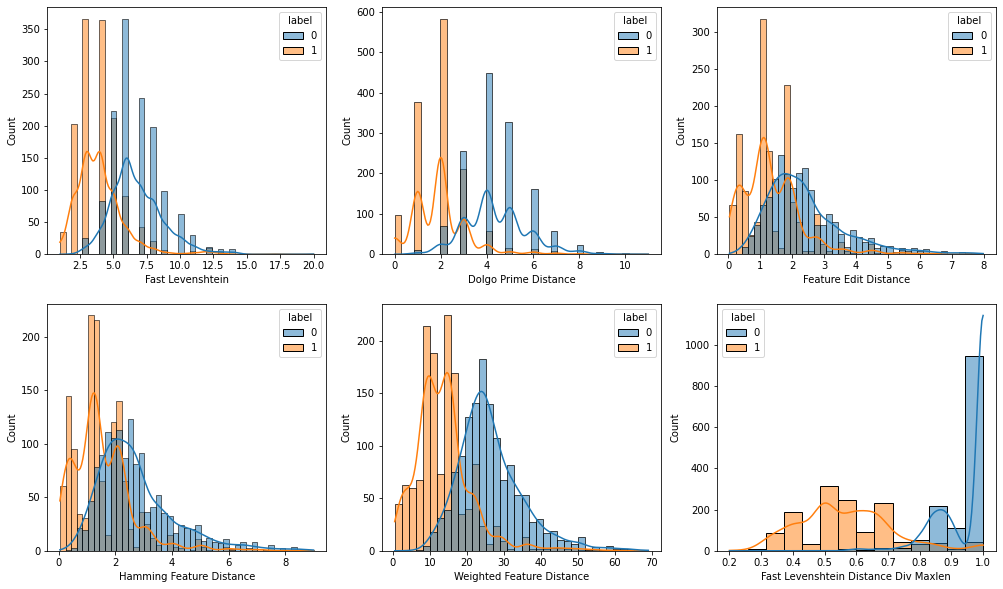

In [26]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.histplot(data= Epi_result, x=dist_arr[i,j], hue="label", ax=axs[i][j], legend=True, kde=True)

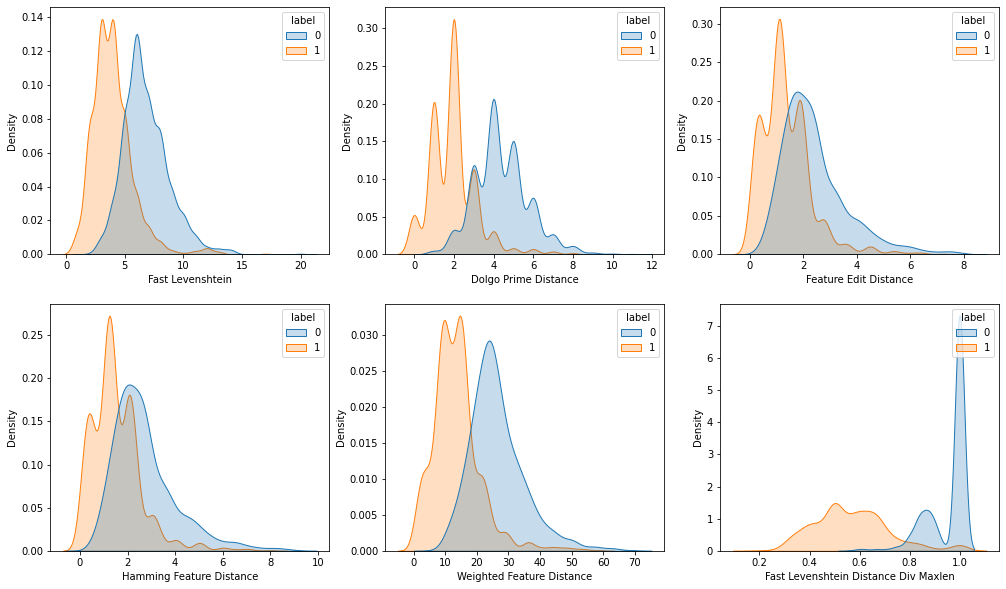

In [27]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= Epi_result, x=dist_arr[i,j], hue="label", shade=1, ax=axs[i][j], legend=True)

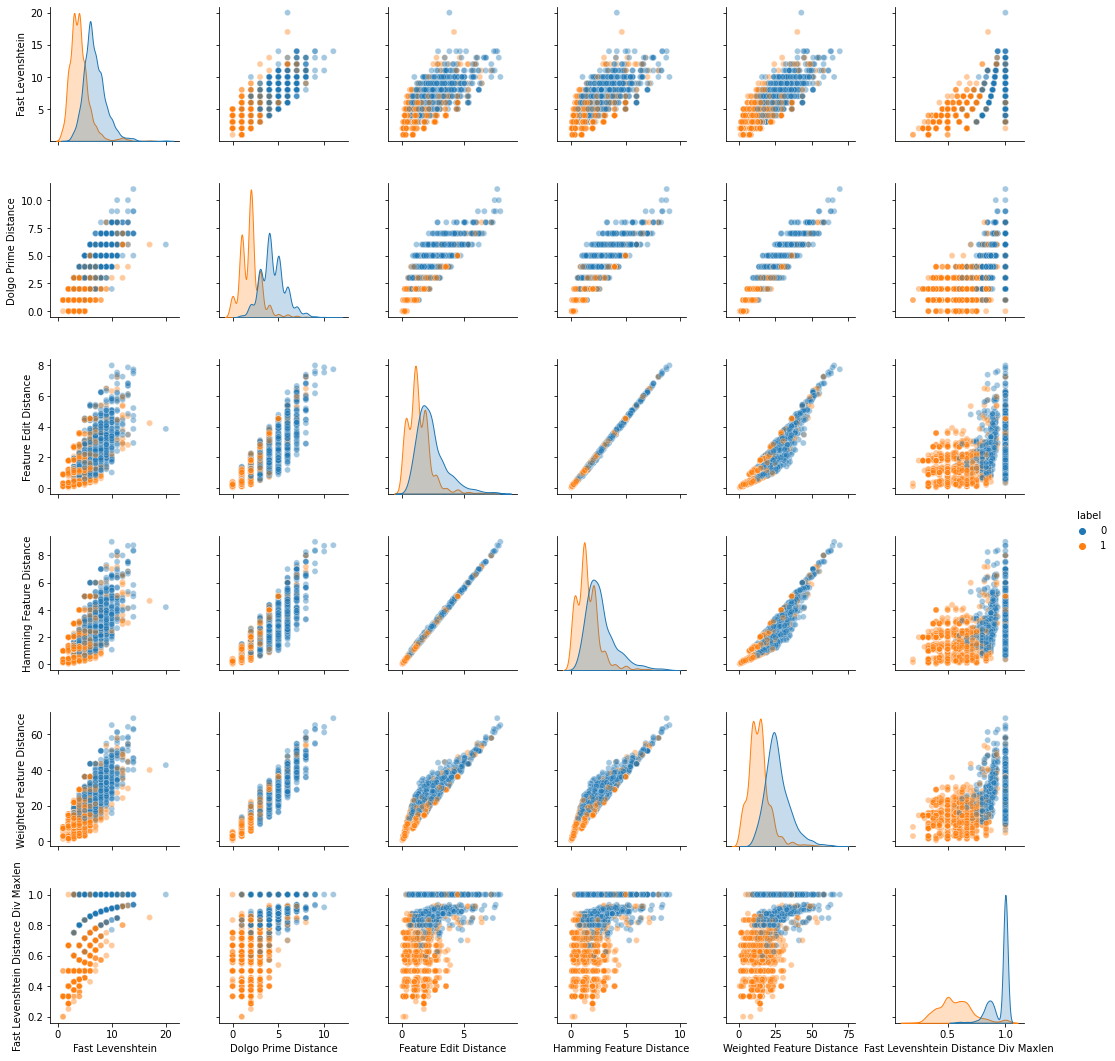

In [28]:
sns.pairplot(data=Epi_result, hue='label',plot_kws={'alpha':0.4})

In [29]:
max_accuracy = 0
max_accuracy_dist = ""
max_f1 = 0
max_f1_dist =""
for edit_dist in edit_dists_names:
    x_train, x_test, y_train, y_test = train_test_split(Epi_result[[edit_dist]], Epi_result["label"], train_size=0.6)
    clf = LogisticRegression().fit(x_train, y_train)
    report = classification_report(y_test, clf.predict(x_test), output_dict=True)
    if report["accuracy"] > max_accuracy:
        max_accuracy_dist = edit_dist
        max_accuracy = report["accuracy"]
    if report['1']["f1-score"] > max_f1:
        max_f1_dist = edit_dist
        max_f1 = report['1']["f1-score"]
    report = pd.DataFrame(report).transpose()
    report.to_csv(f'Epi_{edit_dist}.csv', index= True)

In [30]:
print(f"{max_accuracy_dist} scored the best accuracy : {max_accuracy}")
print(f"{max_f1_dist} scored the best f1-score : {max_f1}")

Fast Levenshtein Distance Div Maxlen scored the best accuracy : 0.9348025711662076
Fast Levenshtein Distance Div Maxlen scored the best f1-score : 0.9346826126954922


## Working with Wiktionary's IPAs

In [31]:
Wiki_L1_L2 = pd.read_csv("Hindi-Persian.csv")

In [32]:
Wiki_L1_L2 = Wiki_L1_L2[Wiki_L1_L2["original_word_ipas"]!="[]"]
Wiki_L1_L2 = Wiki_L1_L2[Wiki_L1_L2["loan_word_ipas"]!="[]"]

In [33]:
Wiki_L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'..."
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/']
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a..."
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/']
5,अंदाज़,اندازه,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/andɑːza/', '/andɒːza/', '/ændɒːze/', '/andɔ..."


In [34]:
Wiki_L1_L2.shape

(724, 4)

In [35]:
for dist, name  in zip(edit_dists, edit_dists_names):
    Wiki_L1_L2[name] = Wiki_L1_L2.apply(lambda x:min([dist(i, j) for i in str(x["loan_word_ipas"]).strip('][').split(", ") for j in str(x["original_word_ipas"]).strip('][').split(", ")]), axis=1)

In [36]:
Wiki_L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'...",1,0,0.187500,0.208333,2.125,0.090909
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/'],0,0,0.000000,0.000000,0.000,0.000000
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a...",0,0,0.000000,0.000000,0.000,0.000000
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/'],5,0,0.333333,0.333333,3.250,0.454545
5,अंदाज़,اندازه,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/andɑːza/', '/andɒːza/', '/ændɒːze/', '/andɔ...",4,1,1.062500,1.166667,8.750,0.333333


In [37]:
Wiki_L1_L2_ = Wiki_L1_L2.copy()
Wiki_L1_L2_ = Wiki_L1_L2_.drop(edit_dists_names , axis=1)
idx = np.random.permutation(Wiki_L1_L2_.index)
Wiki_L1_L2_["original_word"] = Wiki_L1_L2_["original_word"].reindex(idx).reset_index(drop=True)
Wiki_L1_L2_["original_word_ipas"] = Wiki_L1_L2_["original_word_ipas"].reindex(idx).reset_index(drop=True)

In [38]:
Wiki_L1_L2["label"] = 1
Wiki_L1_L2_["label"] = 0
for dist, name  in zip(edit_dists, edit_dists_names):
    Wiki_L1_L2_[name] = Wiki_L1_L2_.apply(lambda x:min([dist(i, j) for i in str(x["loan_word_ipas"]).strip('][').split(", ") for j in str(x["original_word_ipas"]).strip('][').split(", ")]), axis=1)

In [39]:
Wiki_L1_L2_.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,label,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen
0,अंगूर,مذهب,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/maˈzab/', '/mazˈhab/', '[mæzˈhæb]']",0,7,4,1.333333,1.541667,25.000,0.636364
1,अंगूरी,غلط,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']","['/ɣa.li.tˤa/', '/ɣa.latˤ/', '/ɣa.latˤ/', '/ɣa...",0,8,3,1.354167,1.541667,26.750,0.571429
2,अंजाम,خیریه,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/xajɾiːjja/', '/xajɾiːjja/', '/xejɾiːjje/', ...",0,9,6,3.687500,4.125000,39.125,0.692308
3,अंदर,فارغ,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']","['/faː.riɣ/', '/fɑːɾiɣ/', '/fɒːɾɪɣ/', '/fɒːɾeɢ...",0,7,4,1.229167,1.541667,23.375,0.636364
5,अंदाज़,چراغ,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/t͡ʃiɾɑːɣ~t͡ʃaɾɑːɣ/', '/t͡ʃɪɾɒːɣ~t͡ʃaɾɒːɣ/',...",0,7,3,1.104167,1.333333,20.125,0.538462


In [40]:
Wiki_L1_L2.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label
0,अंगूर,انگور,"['/əŋ.ɡuːɾ/', '[ə̃ŋ.ɡuːɾ]']","['/anɡuːɾ/', '/anɡuːɾ/', '/ænɡuːɾ/', '/anɡuɾ/'...",1,0,0.187500,0.208333,2.125,0.090909,1
1,अंगूरी,انگوری,"['/əŋ.ɡuː.ɾiː/', '[ə̃ŋ.ɡuː.ɾiː]']",['/əŋ.ɡuː.ɾiː/'],0,0,0.000000,0.000000,0.000,0.000000,1
2,अंजाम,انجام,"['/ən.d͡ʒɑːm/', '[ə̃n̪.d͡ʒä̃ːm]']","['/and͡ʒɑːm/', '/and͡ʒɒːm/', '/ænd͡ʒɒːm/', '/a...",0,0,0.000000,0.000000,0.000,0.000000,1
3,अंदर,اندر,"['/ən.d̪əɾ/', '[ə̃n̪.d̪əɾ]']",['/andur/'],5,0,0.333333,0.333333,3.250,0.454545,1
5,अंदाज़,اندازه,"['/ən.d̪ɑːd͡ʒ/', '[ə̃n̪.d̪äːd͡ʒ]', '/ən.d̪ɑːz/...","['/andɑːza/', '/andɒːza/', '/ændɒːze/', '/andɔ...",4,1,1.062500,1.166667,8.750,0.333333,1


In [41]:
Wiki_result = pd.concat([Wiki_L1_L2, Wiki_L1_L2_])
Wiki_result = shuffle(Wiki_result).reset_index(drop=True)
Wiki_result.head()

,loan_word,original_word,loan_word_ipas,original_word_ipas,Fast Levenshtein,Dolgo Prime Distance,Feature Edit Distance,Hamming Feature Distance,Weighted Feature Distance,Fast Levenshtein Distance Div Maxlen,label
0,इस्लाम,اسلام,"['/ɪs.lɑːm/', '[ɪs̪.l̪ä̃ːm]', '/is.lam/', '[is...","['/ɪs.lɑm/', '/ʔislɑːm/', '/ʔɪslɒːm/', '/ʔeslɒ...",0,0,0.000000,0.000000,0.000,0.000000,1
1,फ़व्वारा,NaN,"['/pʰəʋ.ʋɑː.ɾɑː/', '[pʰəʋ.ʋäː.ɾäː]', '/fəʋ.ʋɑː...",NaN,15,4,3.854167,4.541667,35.625,1.000000,0
2,अज़ान,عیاشی,"['/ə.d͡ʒɑːn/', '[ə.d͡ʒä̃ːn̪]', '/ə.zɑːn/', '[ə...","['/(ʔ)ə̯i.jɑː.ʃiː/', '/(ʔ)əj.jɑː.ʃiː/']",9,5,3.166667,3.500000,31.875,0.529412,0
3,गुज़श्ता,گذشته,"['/ɡʊ.d͡ʒəʃ.t̪ɑː/', '[ɡʊ.d͡ʒəʃ.t̪äː]', '/ɡʊ.zə...","['/ɡuðaʃta/', '/ɡʊzaʃta/', '/ɡozæʃte/', '/ɡuza...",6,0,0.166667,0.166667,1.500,0.400000,1
4,सिफ़ारिश,NaN,"['/sɪ.pʰɑː.ɾɪʃ/', '[s̪ɪ.pʰäː.ɾɪʃ]', '/sɪ.fɑː.ɾ...",NaN,14,5,3.979167,4.458333,35.500,1.000000,0


In [42]:
Wiki_result.to_csv("Wiki_result.csv", index=True)

In [43]:
dist_arr = np.array(edit_dists_names).reshape(-1,3)
dist_arr

array([['Fast Levenshtein', 'Dolgo Prime Distance',
        'Feature Edit Distance'],
       ['Hamming Feature Distance', 'Weighted Feature Distance',
        'Fast Levenshtein Distance Div Maxlen']], dtype='<U36')

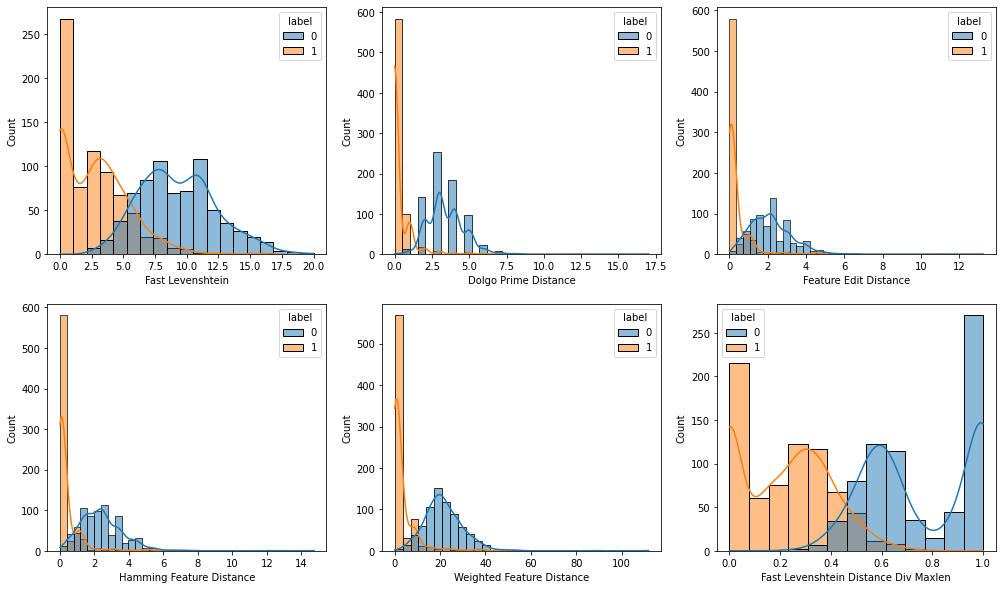

In [44]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.histplot(data= Wiki_result, x=dist_arr[i,j], hue="label", ax=axs[i][j], legend=True, kde=True)

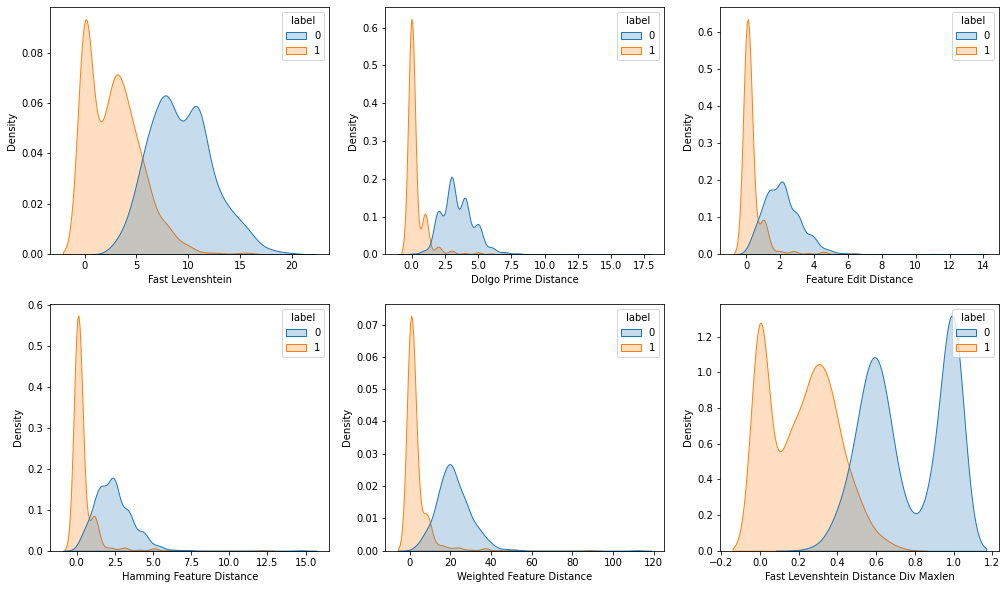

In [46]:
f, axs = plt.subplots(len(dist_arr), len(dist_arr[0]), figsize=(17,10))
for i in range(len(dist_arr)):
    for j in range(len(dist_arr[0])):
        sns.kdeplot(data= Wiki_result, x=dist_arr[i,j], hue="label", shade=1, ax=axs[i][j], legend=True)

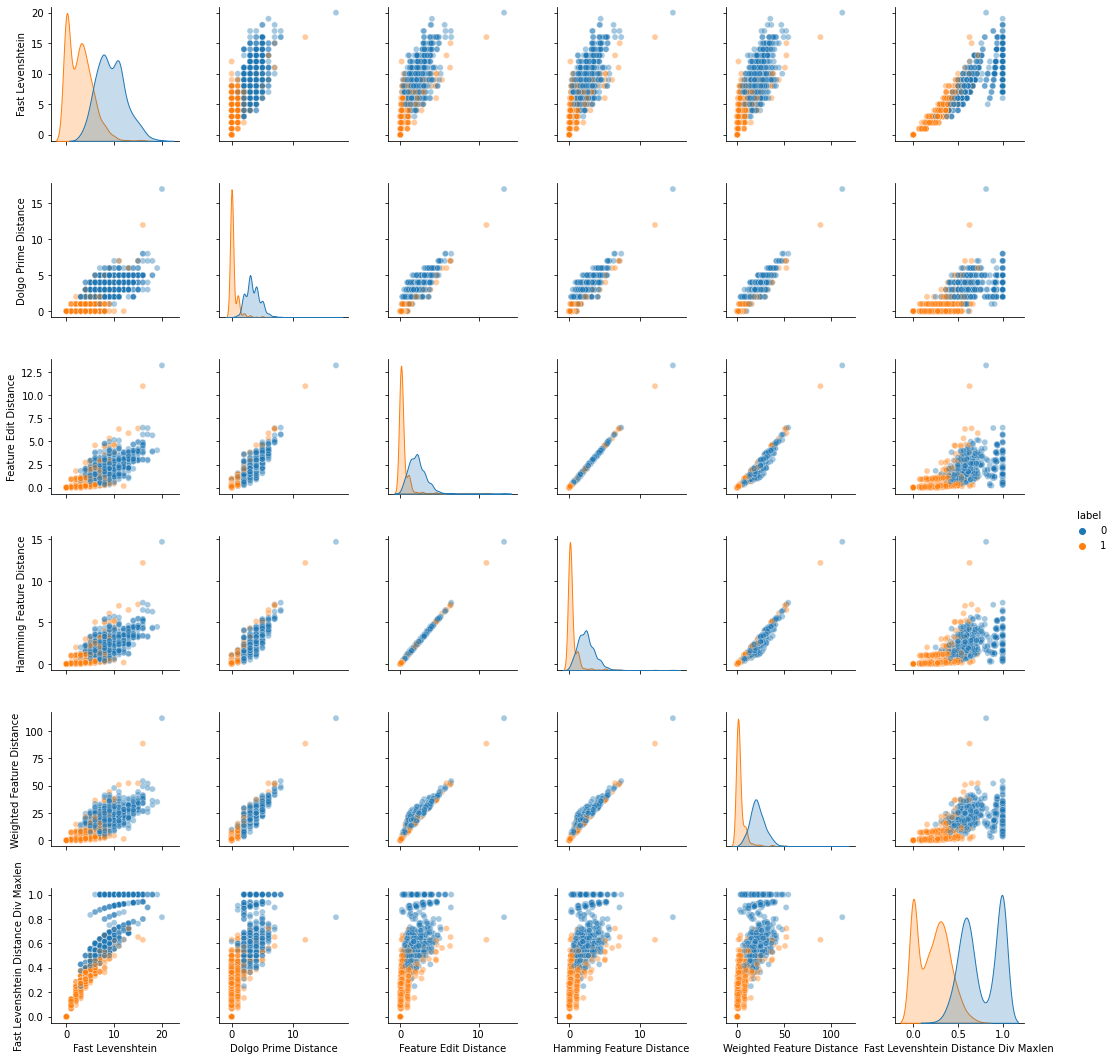

In [47]:
sns.pairplot(data=Wiki_result, hue='label',plot_kws={'alpha':0.4})
sns.set(rc={'figure.figsize':(40,40)})

In [48]:
max_accuracy = 0
max_accuracy_dist = ""
max_f1 = 0
max_f1_dist =""
for edit_dist in edit_dists_names:
    x_train, x_test, y_train, y_test = train_test_split(Wiki_result[[edit_dist]], Wiki_result["label"], train_size=0.6)
    clf = LogisticRegression().fit(x_train, y_train)
    report = classification_report(y_test, clf.predict(x_test), output_dict=True)
    if report["accuracy"] > max_accuracy:
        max_accuracy_dist = edit_dist
        max_accuracy = report["accuracy"]
    if report['1']["f1-score"] > max_f1:
        max_f1_dist = edit_dist
        max_f1 = report['1']["f1-score"]
    report = pd.DataFrame(report).transpose()
    report.to_csv(f'Wiki_{edit_dist}.csv', index= True)

In [49]:
print(f"{max_accuracy_dist} scored the best accuracy : {max_accuracy}")
print(f"{max_f1_dist} scored the best f1-score : {max_f1}")

Dolgo Prime Distance scored the best accuracy : 0.9534482758620689
Dolgo Prime Distance scored the best f1-score : 0.9535283993115319
